### Based on the paper from Goodwill et al.

In [34]:
import math
import os
import h5py

import numpy as np
import pandas as pd
import seaborn as sns
from numpy.testing import assert_almost_equal
from scipy import stats
from tqdm import tqdm
from src.tools.cache import get_cache, cache_np
from src.tools.plotter import line_plot

from src.tools.traceloader import ASCAD, TraceCategory

sns.set_style("whitegrid")

In [35]:
class NBCache:
    def __init__(self, path):
        self.path = path

    def np(self, name: str, *args):
        res = cache_np(f"{self.path}/{name}", *args)
        setattr(self, name, res)

        return res

    def cts(self, name: str, *args):
        res = cache_cts(f"{self.path}/{name}", *args)
        setattr(self, name, res)

        return res

cache = NBCache("tvla/t_test")

In [36]:
trace_len = 50
sample_size = 350

def gen_trace(key=0, mu=128):
    return np.array([np.random.normal(mu + (key/256 - 1), 1, trace_len) for _ in range(sample_size)], dtype=np.uint8)

def gen_mask_trace(mu=128):
    random_keys = np.random.uniform(0, 256, sample_size) / 256

    return np.array([np.random.normal(mu + (rk - 1), 1, trace_len) for rk in random_keys], dtype=np.uint8)

tg_a1 = gen_trace(0)
tg_a2 = gen_trace(256)
tg_b = gen_mask_trace()

gen_mask_trace()

array([[126, 126, 128, ..., 128, 128, 128],
       [126, 130, 127, ..., 128, 126, 128],
       [126, 126, 128, ..., 126, 127, 126],
       ...,
       [127, 127, 125, ..., 127, 126, 127],
       [127, 128, 126, ..., 127, 126, 127],
       [127, 128, 127, ..., 128, 127, 125]], dtype=uint8)

In [37]:
def plot_longform(traces):
    sns.set_style('whitegrid')

    longform = []
    for trace in traces:
        for ix in range(len(trace)):
            longform.append((ix, trace[ix]))

    cols = ["Sample point", "Power"]
    df = pd.DataFrame(longform, columns=cols)
    sns.lineplot(data=df, x=cols[0], y=cols[1])

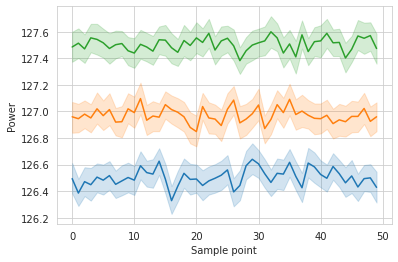

In [38]:
plot_longform(gen_trace(0))
plot_longform(gen_mask_trace())
plot_longform(gen_trace(256))


In [39]:
def device_fails(left: np.array, right: np.array):
    return np.array(left * right).any()

def stats_t_test(a, b, p=.95):
    return stats.ttest_ind(a, b, equal_var=False)[1] > p

def gen_rvs(mean=5):
    return lambda: np.array([stats.norm.rvs(loc=mean,scale=.1,size=50) for _ in range(50)])

In [40]:
def gen_ctable(sample):
    return np.array([np.bincount(t, minlength=256) for t in sample])

def ctable_mv(ctable: np.array, num_observations: int):
    """
    Calculates the mean and variance from a contingency table with a corresponding number of observations.
    """
    # Using 128-bit floats prevents some rounding errors when comparing with the np implementation of var and mean.
    ixs = np.arange(0, len(ctable), dtype=np.float128)

    mu = (ctable * ixs).sum() / num_observations
    sigma2 = ((ctable * ixs ** 2).sum() / num_observations) - (mu ** 2)

    return mu, sigma2

In [41]:
trc = np.array([round(np.random.uniform(0, 255)) for _ in range(100000)])
trc_mv = ctable_mv(np.bincount(trc, minlength=256), len(trc))

# Compare with actual mean and variance
assert_almost_equal(trc_mv, (trc.mean(), trc.var()))

In [42]:
def get_mvs(samples):
    return np.array([np.moveaxis(np.array([s.mean(axis=0), s.var(axis=0)]), 0, 1) for s in samples.astype(np.float128)])

sps = np.array([gen_trace(5), gen_trace(5)])
get_mvs(sps).shape

(2, 50, 2)

In [43]:
def make_t_test_mv(n):
    def test(a, b, p):
        ma, sa = a
        mb, sb = b

        s = np.sqrt((sa + sb) / 2)
        t = (ma - mb)/(s * np.sqrt(2 / n))
        dof = 2 * n - 2

        t_abs = np.abs(t).astype(np.float64)
        return stats.distributions.t.sf(t_abs, dof) * 2 > p

    return test

t_mv = [make_t_test_mv(350)(*mv, .95) for mv in np.moveaxis(get_mvs(sps), 0, 1)]
t_base = np.array(stats.stats.ttest_ind(*sps)[1] > .95)

print(f"Should be larger than 0 for the assertion to make sense: ({sum(t_mv)}).")
assert_almost_equal(t_mv, t_base)

Should be larger than 0 for the assertion to make sense: (1).


In [44]:
def tvla(test, samples_a, samples_b, p=.95):
    """
    Applies some given statistical test against the given samples.

    @param test: statistical test function that takes two samples and returns test values.
    @param samples_a: Four sample sets containing s samples representing a power trace of length t.
    @param samples_b: Two sample sets containing s samples representing a power trace of length t.
    @param p: Decide whether a device fails using (100 * p)%-confidence interval.
    @return: Whether the device fails on (A against A, A against B).
    """
    # Four different samples from distribution A.
    a, b, c, d = samples_a
    # Two different samples from distribution B.
    x, y = samples_b

    # Test A against A.
    aa1 = test(a, c, p)
    aa2 = test(b, d, p)

    # Test A against B.
    ab1 = test(a, x, p)
    ab2 = test(b, y, p)

    return device_fails(aa1, aa2), device_fails(ab1, ab2)

### TVLA check for default $t$-test.

In [45]:
tvla(stats_t_test, [gen_rvs(5)() for _ in range(4)], (gen_rvs(6)(), gen_rvs(6)()))

(False, False)

### TVLA check for $t$-test with mean and variance as input

In [46]:
mvs_a = np.moveaxis(get_mvs(np.array([gen_rvs(5)() for _ in range(4)])), 1, -1)
mvs_b = np.moveaxis(get_mvs(np.array([gen_rvs(6)() for _ in range(2)])), 1, -1)

tvla(make_t_test_mv(350), mvs_a, mvs_b)

(False, False)

### TVLA Benchmark.

For 1000 samples:
- $\mu_A = 5$ vs. $\mu_B = 5$ yields $(106, 121)$
- $\mu_A = 5$ vs. $\mu_B = 5.1$ yields $(105, 0)$
- $\mu_A = 5$ vs. $\mu_B = 100$ yields $(128, 0)$
- Demo trace vs. masked Demo trace yields $(91, 0)$

In [47]:
def bench(test, gen_one, gen_two, total=20, progress=False):
    acc = np.array([(False, False)] * total)
    it = range(total)
    if progress:
        it = tqdm(it)

    for ix in it:
        acc[ix] = tvla(test, [gen_one() for _ in range(4)], (gen_two(), gen_two()))

    return np.array(acc).sum(axis=0)

In [48]:
print("TVLA - number of failing devices: \t[A vs. A, A vs. B]")
print(f"TVLA for mu = 5 & mu = 5 (rvs): \t{bench(stats_t_test, gen_rvs(5), gen_rvs(5))}")
print(f"TVLA for mu = 5 & mu = 5.1 (rvs): \t{bench(stats_t_test, gen_rvs(5), gen_rvs(5.1))}")
print(f"TVLA for mu = 5 & mu = 100 (rvs): \t{bench(stats_t_test, gen_rvs(5), gen_rvs(100))}")
print(f"TVLA for demo trace & masked trace: \t{bench(stats_t_test, gen_trace, gen_mask_trace)}")

TVLA - number of failing devices: 	[A vs. A, A vs. B]
TVLA for mu = 5 & mu = 5 (rvs): 	[5 3]
TVLA for mu = 5 & mu = 5.1 (rvs): 	[3 0]
TVLA for mu = 5 & mu = 100 (rvs): 	[2 0]
TVLA for demo trace & masked trace: 	[3 0]


## Application of TVLA on ASCAD

In [49]:
ascad = ASCAD()

### Resolve imbalance between traces.

In [50]:
def smote(trace_categories, target_size, dtype=np.uint8):
    def get_point(traces):
        t_shape = traces.shape
        x, y = 0, 0
        while x == y:
            x, y = np.random.randint(t_shape[0]), np.random.randint(t_shape[0])

        smoted_diff = (np.array(traces[y], dtype=int) - np.array(traces[x], dtype=int)) * np.random.uniform(size=t_shape[1])
        smoted_diff = np.array([np.array(t, dtype=dtype) for t in smoted_diff])

        return traces[x] + smoted_diff

    acc = []

    for c_ix, category in enumerate(trace_categories):
        res = np.zeros((len(category), target_size, category[0].shape[1]), dtype=dtype)

        for s_ix, trace_slice in enumerate(category):
            app = [get_point(trace_slice) for _ in range(target_size - len(trace_slice))]

            if len(app) > 0:
                res[s_ix] = np.concatenate((trace_slice, app))
            else:
                res[s_ix] = trace_slice

        acc.append(res)

    return acc

### Create contingency tables from traces.

Generating contingency tables: 100%|██████████| 1/1 [00:00<00:00, 32.62it/s]


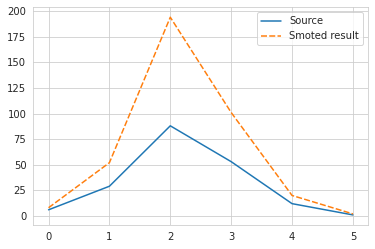

In [51]:
class CTableStore:
    def __init__(self, tc: TraceCategory, num_keys=256):
        self.tc = tc
        self.num_keys = num_keys
        self.size = max([math.ceil(len(self.tc.filter_traces(k)) / 2) for k in range(self.num_keys)])

        t_max = max([self.tc.filter_traces(k).max() for k in range(self.num_keys)]) + 128
        t_min = min([self.tc.filter_traces(k).min() for k in range(self.num_keys)]) + 128

        self.trace_type = np.uint8
        # Maximum value of trace should be lower than the capacity of uint8.
        assert t_min > 0
        assert t_max < np.iinfo(self.trace_type).max

        self.table_type = np.uint16
        # Maximum value of bincount should be lower than the capacity of uint16.
        assert self.size < np.iinfo(self.table_type).max

        self.slices = {}
        self.gen_slices()

        self.smoted = {}
        for k in tqdm(range(self.num_keys), "SMOTEing traces"):
            self.smoted[k] = np.array(smote(self.slices[k], self.size, self.trace_type))

        self.tables = {}
        self.gen_tables()

    def gen_slices(self):
        res = {}

        for k in tqdm(range(self.num_keys), "Slicing up traces"):
            ts = self.tc.filter_traces(k) + 128
            uts = np.array([np.array(t, dtype=self.trace_type) for t in ts])

            np.random.shuffle(uts)
            ts4 = np.array(np.array_split(uts.copy(), 4))
            np.random.shuffle(uts)
            ts2 = np.array(np.array_split(uts, 2))

            res[k] = np.array([ts4, ts2])

        self.slices = res

    def gen_tables(self):
        res = {}

        for k in tqdm(range(self.num_keys), "Generating contingency tables"):
            res[k] = {}
            for c, category in enumerate(self.smoted[k]):
                res[k][c] = {}
                for s, trace_slice in enumerate(category):
                    ts = np.moveaxis(trace_slice, 0, -1)
                    res[k][c][s] = np.array(
                        [np.array(np.bincount(t, minlength=256), dtype=self.table_type) for t in ts])

        self.tables = res

cts = CTableStore(ascad.masked.profile, 1)

test_cts_split = np.array([i[0] for i in cts.slices[0][0][0]])
test_cts_data = np.array([i[0] for i in cts.smoted[0][0][0]])

sns.lineplot(data=pd.DataFrame(zip(np.bincount(test_cts_split)[-6:], np.bincount(test_cts_data)[-6:]), columns=["Source", "Smoted result"]))

assert np.all(cts.tables[0][0][0][0] == np.bincount(test_cts_data, minlength=256))

In [52]:
def cache_cts(name: str, t_cat: TraceCategory):
    fname = f'{get_cache()}/{name}.hdf5'

    if not os.path.exists(fname):
        f = h5py.File(fname, 'a')

        ct = CTableStore(t_cat)
        for k, key in tqdm(ct.tables.items(), "Storing tables"):
            for c, category in key.items():
                grp = f.create_group(f"key_{str(k).zfill(3)}/cat_{c}")
                for t, trace_slice in category.items():
                    arr = np.array([sp.astype(np.uint16) for sp in trace_slice])
                    grp.create_dataset(f"slice_{t}", data=arr)

        f.close()

    return h5py.File(fname, 'r')

ct_default = cache.cts("ascad_default", ascad.default.profile)
ct_random = cache.cts("ascad_random", ascad.random.profile)
ct_mask = cache.cts("ascad_mask", ascad.masked.profile)

### Retrieve mean and variance from contingency tables.

In [53]:
def get_num_observations(f: h5py.File):
    return f["key_000"]["cat_0"]["slice_0"][0].sum()

def get_trace_len(f: h5py.File):
    return len(f["key_000"]["cat_0"]["slice_0"])

def get_mv(f: h5py.File):
    num_obs = get_num_observations(f)
    slice_len = get_trace_len(f)

    def convert(sample_pts: np.array):
        arr = np.array([np.zeros(2, dtype=np.float128)] * slice_len)
        for sp, sample_pt in enumerate(sample_pts):
            arr[sp] = np.array(ctable_mv(sample_pt, num_obs))

        return arr

    return np.array(
        [np.array(
            [np.array(
                [convert(f[k][c][s]) for s in f[k][c]])
            for c in f[k]])
        for k in tqdm(f, "Retrieving mean and variance")])

mv_default = cache.np("mv_default", get_mv, ct_default)
mv_random = cache.np("mv_random", get_mv, ct_random)
mv_masked = cache.np("mv_masked", get_mv, ct_mask)

In [54]:
len(ct_default["key_000"]["cat_0"]["slice_0"])

1400

In [55]:
# Number of observations does not vary on the SMOTEd data.
obs_default = get_num_observations(ct_default)
obs_mask = get_num_observations(ct_mask)
obs_random = get_num_observations(ct_random)

<AxesSubplot:>

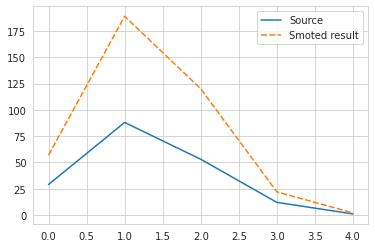

In [56]:
test_sample_pt = np.array([i[0] for i in cts.slices[0][0][0]])
test_sample_pt_smote = np.array([i[0] for i in np.array(smote(cts.slices[0], 400)[0][0])])

assert min(test_sample_pt) == min(test_sample_pt_smote)
assert max(test_sample_pt) == max(test_sample_pt_smote)

bc_spt = np.bincount(test_sample_pt + 128)[-5:]
bc_spt_s = np.bincount(test_sample_pt_smote)[-5:]

sns.lineplot(data=pd.DataFrame(zip(bc_spt, bc_spt_s), columns=["Source", "Smoted result"]))

[Text(0.5, 1.0, 'Mean and variance of first key, category and slice.\n')]

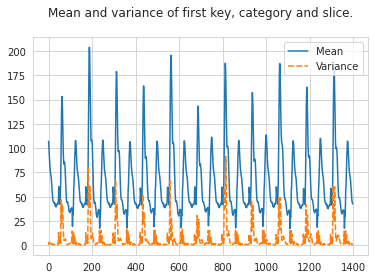

In [57]:
g = sns.lineplot(data=pd.DataFrame(mv_default[0][0][0], columns=["Mean", "Variance"]))
g.set(title="Mean and variance of first key, category and slice.\n")

In [58]:
def make_left_right(stat_moments):
    def get_left(k):
        return stat_moments[k][1][0]

    def get_right(k):
        return stat_moments[k][1][1]

    return get_left, get_right

def get_diff(stat_moments, key_range=range(256)):
    left, right = make_left_right(stat_moments)

    kr = key_range

    dist_neq = [abs(left(i) - right(j)) for i in kr for j in kr if i != j]
    dist_eq = [abs(left(i) - right(i)) for i in kr]

    return np.mean(dist_neq, axis=0) - np.mean(dist_eq, axis=0)

def plot_highest_diff(mvs, heat, title):
    key_selected = get_max_index(heat)

    mv_diff = pd.DataFrame({"Mean": np.moveaxis(get_diff(mvs, key_selected), 0, -1)[0]})
    line_plot(mv_diff, title=title)
    line_plot(mv_diff, xlim=POI, title=f"{title} at PoI {POI}")

### Investigate dataset.

In [59]:
POI = 59, 85

def get_num_moments(stat_moments):
    return len(stat_moments[0][0][0][0])

def get_heatmap(stat_moments):
    num_moments = get_num_moments(stat_moments)
    num_keys = len(stat_moments)

    res = np.zeros((num_keys, num_keys, num_moments), dtype=np.float128)
    for i in tqdm(range(num_keys)):
        for j in range(num_keys):
            if i == j:
                res[i][j] = np.array([0] * num_moments)
            else:
                diff = get_diff(mv_default, [i, j])
                diff[np.less(diff, 0)] = 0
                # Difference ratio over the rest of the trace
                res[i][j] = diff[POI[0]:POI[1]].sum(axis=0) / diff.sum(axis=0)

    return res

heat_default = cache.np("heat_default", get_heatmap, mv_default)
heat_masked = cache.np("heat_masked", get_heatmap, mv_masked)
heat_random = cache.np("heat_random", get_heatmap, mv_random)

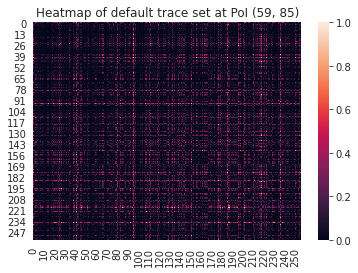

In [60]:
def get_heat_moment(heatmap, moment):
    return np.moveaxis(heatmap, 2, 0)[moment]

def plot_heatmap(heatmap, title):
    mean = get_heat_moment(heatmap, 0)
    mean_norm = mean / mean.max()
    sns.heatmap(data=mean_norm).set(title=title)

plot_heatmap(heat_default, f"Heatmap of default trace set at PoI {POI}")

In [61]:
def get_max_index(heatmap, moment=0):
    heat_moment = get_heat_moment(heatmap, moment)
    return np.unravel_index(heat_moment.argmax(), heat_moment.shape)

get_max_index(heat_default)

(187, 218)

## Problem statement

1. There is a first-order moment leakage visible in the standard ASCAD random-keys database.
2. This leakage is not visible in the masked-key and shuffled variants of this database.
3. The performance in terms of TP/FP rate is better for the masked-key and shuffled variants than it is for the
standard database.
4. It does not matter where the Point of Interest is located, while I would suspect that the performance varies for the
location of the PoI and that performance would be better in areas with a high moment difference.

#### Possible solutions (in order of likelihood):
1. There is a bug in the TVLA method.
2. There is a bug in the T-Test.
3. There is something fundamentally flawed with my understanding of the ASCAD database.

### Moment differences for each dataset.

The moment difference calculated as follows:
- Take keys $k_a$ and $k_b$, and their mean (first-order statistical moment) $\mu_a$ and $\mu_b$ per sample point.
- The euclidean distance between means from equal key $\eta = $ dist($\mu_{a}, \mu_b$) where $a = b$
- The euclidean distance between means from different key $\delta = $ dist($\mu_{a}, \mu_b$) where $a \neq b$
- Then the moment difference is $\eta - \delta$.

A positive moment difference reflects larger differences between equal keys and lower differences between different
keys, possibly indicating a leakage in this order of statistical moment.

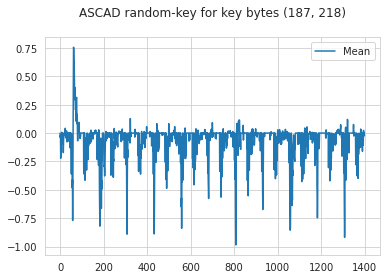

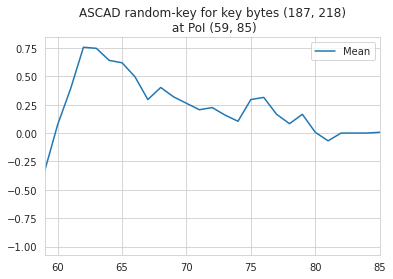

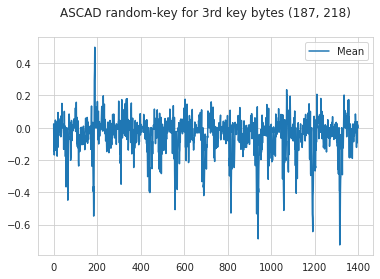

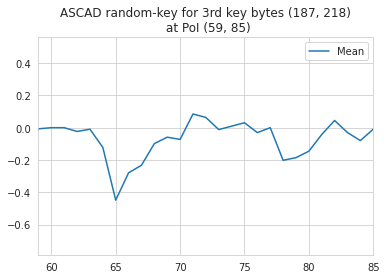

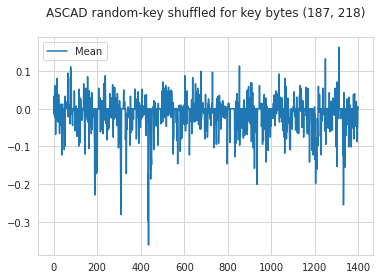

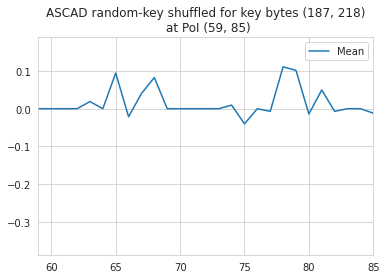

In [62]:
plot_highest_diff(mv_default, heat_default, f"ASCAD random-key for key bytes {get_max_index(heat_default)}\n")
plot_highest_diff(mv_masked, heat_masked, f"ASCAD random-key for 3rd key bytes {get_max_index(heat_masked)}\n")
plot_highest_diff(mv_random, heat_random, f"ASCAD random-key shuffled for key bytes {get_max_index(heat_masked)}\n")

In [63]:
def tvla_prep(mvs, key_left, key_right, num_obs, poi=(None, None), p=.99):
    def at_poi(ts):
        return np.moveaxis(np.array([t[poi[0]:poi[1]] for t in ts]), 2, 1)

    mvs_left, mvs_right = mvs[key_left], mvs[key_right]

    a = at_poi(mvs_left[0])
    b = at_poi(mvs_right[1])

    return tvla(make_t_test_mv(num_obs), a, b, p)

# TODO strange value for p, isn't it?
p_max = .75

tvla_default = tvla_prep(mv_default, *get_max_index(heat_default), obs_default, POI, p_max)
tvla_masked = tvla_prep(mv_masked, *get_max_index(heat_masked), obs_default, POI, p_max)
tvla_random = tvla_prep(mv_masked, *get_max_index(heat_masked), obs_default, POI, p_max)

print(f"TVLA result for default trace set: {tvla_default}")
print(f"TVLA result for masked trace set: {tvla_masked}")
print(f"TVLA result for random trace set: {tvla_random}")

TVLA result for default trace set: (True, False)
TVLA result for masked trace set: (True, True)
TVLA result for random trace set: (True, True)


In [64]:
def tvla_keys(mvs, num_obs, poi=(None, None), p=.95):
    num_keys = len(mvs)
    res = np.zeros((num_keys, num_keys, 2))

    for i in tqdm(range(num_keys)):
        for j in range(num_keys):
            res[i][j] = tvla_prep(mvs, i, j, num_obs, poi, p)

    return res

tks_default = cache.np("tvla_default_95", tvla_keys, mv_default, obs_default, POI, .95)
tks_masked = cache.np("tvla_masked_95", tvla_keys, mv_masked, obs_default, POI, .95)
tks_random = cache.np("tvla_random_95", tvla_keys, mv_random, obs_default, POI, .95)

In [69]:
def analyse_tvla(tvla_results, heatmap):
    sums = np.zeros(7)

    for k1, key_1 in enumerate(tvla_results):
        for k2, key_2 in enumerate(key_1):
            h = heatmap[k1][k2]
            l, r = key_2

            tp = l * (not r)
            fp = r * (not l)
            tph = h[0] * tp
            fph = h[0] * fp

            sums += np.array([*key_2, tp, fp, tph, fph, h[0]])

    total = len(tvla_results) ** 2
    print(f"For a total of {total} key combinations: \n")

    print(f"Left fails  {int(sums[0])} times.")
    print(f"Right fails {int(sums[1])} times. \n")

    print(f"True positives:  {int(sums[2])}")
    print(f"False positives: {int(sums[3])} \n")

    print(f"Average mean diff: {sums[6] / total:.4f}")
    print(f"Average mean diff for True positives:  {sums[4] / sums[0]:.4f}")
    print(f"Average mean diff for False positives: {sums[5] / (total - sums[0]):.4f} \n")

## TVLA analysis on ASCAD

### Analysis default

In [67]:
analyse_tvla(tks_default, heat_default)

For a total of 65536 key combinations: 

Left fails  1536 times.
Right fails 1965 times. 

True positives:  1472
False positives: 1901 

Average mean diff: 0.0475
Average mean diff for True positives:  0.0556
Average mean diff for False positives: 0.0010 



### Analysis masked

In [73]:
analyse_tvla(tks_masked, heat_masked)

For a total of 65536 key combinations: 

Left fails  768 times.
Right fails 1976 times. 

True positives:  727
False positives: 1935 

Average mean diff: 0.0475
Average mean diff for True positives:  0.0315
Average mean diff for False positives: 0.0014 



### Analysis shuffled

In [72]:
analyse_tvla(tks_random, heat_random)

For a total of 65536 key combinations: 

Left fails  768 times.
Right fails 1954 times. 

True positives:  737
False positives: 1923 

Average mean diff: 0.0475
Average mean diff for True positives:  0.0319
Average mean diff for False positives: 0.0015 

